In [1]:
%load_ext autoreload
%autoreload 2

import anndata as ad
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
from mmd_wrapper.utilities import alignment_visualize, pairwise_error
import numpy as np
import pandas as pd

from commando import ComManDo

2021-11-14 13:49:40.201075: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-14 13:49:40.201117: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


# Read Data

In [2]:
data_mod1 = ad.read_h5ad('OPSCA/openproblems_bmmc_multiome_starter/openproblems_bmmc_multiome_starter.mod1.h5ad')
data_mod2 = ad.read_h5ad('OPSCA/openproblems_bmmc_multiome_starter/openproblems_bmmc_multiome_starter.mod2.h5ad')

In [3]:
X1 = data_mod1.X
X2 = data_mod2.X

# Run Mapping

In [4]:
commando_optimized = (
    ComManDo(
        distance_mode='spearman',
        epoch_pd=500,
        log_pd=500,
        two_step_aggregation = 'random',
        # two_step_pd_large=2000,
        two_step_include_large=False,
        two_step_log_pd=2,
        two_step_num_partitions=2,
        two_step_redundancy=2,
    )
    .fit_transform([X1, X2])
)

use random seed: 666

Beginning redundant step 1
Two-Step group sizes
Min: 250
Max: 250
Shape of Raw data
Dataset 0: (500, 600)
Dataset 1: (500, 600)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 1
Calculating intra-group F #2
epoch:[500/500] err:0.0434 alpha:0.9045
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
Calculating intra-group F #2
epoch:[500/500] err:0.0563 alpha:1.1733
---------------------------------
Find correspondence between Dataset 2 and Dataset 2
Calculating intra-group F #2
epoch:[500/500] err:0.0398 alpha:0.9135
Finished Matching!

Beginning redundant step 2
Two-Step group sizes
Min: 250
Max: 250
Shape of Raw data
Dataset 0: (500, 600)
Dataset 1: (500, 600)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 1
Calculating intra-group F #2
epoch:[500/500] err:0.0434 alpha:0.9045
---------------------------------
Find correspondence betw

In [5]:
commando_normal = (
    ComManDo(
        distance_mode='euclidean',
        epoch_pd=2000,
        log_pd=1000,
    )
    .fit_transform([X1, X2])
)

use random seed: 666
Shape of Raw data
Dataset 0: (500, 600)
Dataset 1: (500, 600)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 1
epoch:[1000/2000] err:0.2451 alpha:0.7782
epoch:[2000/2000] err:0.2526 alpha:0.9008
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[1000/2000] err:0.9675 alpha:4.7533
epoch:[2000/2000] err:0.9727 alpha:5.5065
---------------------------------
Find correspondence between Dataset 2 and Dataset 2
epoch:[1000/2000] err:0.7438 alpha:0.7918
epoch:[2000/2000] err:0.6264 alpha:0.9178
Finished Matching!
---------------------------------
Performing NLMA
Constructing Dense W
Applying Coefficients
Computing Laplacian
Calculating eigenvectors
Filtering eigenvectors
Perfoming mapping
---------------------------------
ComManDo Done!
Time: 28.540947198867798 seconds


# Evaluate

ComManDo Optimized Pairwise Error: 3.2723075023386627
ComManDo Normal Pairwise Error:    6.3064546523673926


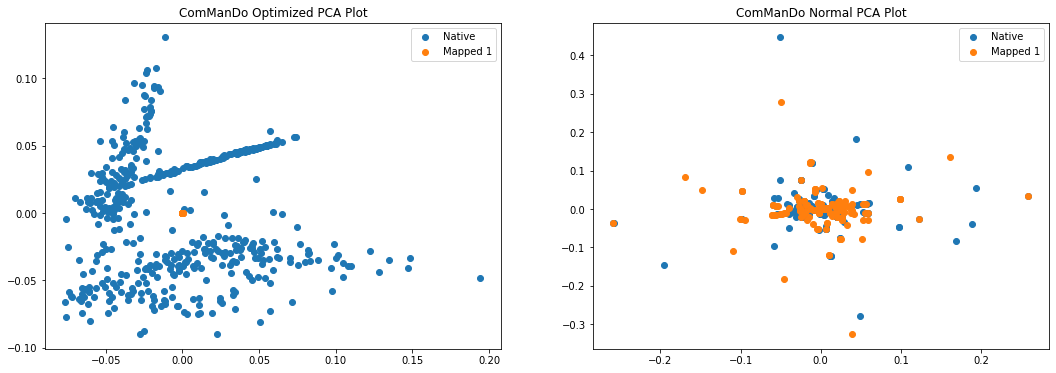

In [6]:
print('ComManDo Optimized Pairwise Error: ' + str(pairwise_error(*commando_optimized, normalize_by_feature=True)))
print('ComManDo Normal Pairwise Error:    ' + str(pairwise_error(*commando_normal, normalize_by_feature=True)))

plt.subplots(figsize=(18, 6))
plt.subplot(1, 2, 1)
alignment_visualize(*commando_optimized, alg_name='ComManDo Optimized')

plt.subplot(1, 2, 2)
alignment_visualize(*commando_normal, alg_name='ComManDo Normal')